In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pdb
from hmmlearn import hmm
# Machine learning package
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

def scale_list(l, to_min, to_max):
    # map the number in l to [to_min, to_max]
    # step1: map the number in l to [0, 1]
    # step2: multiply the new l in step 1 by (to_max - to_min)
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]
    
# Get classification report    
def get_performance(report,aoc,model_score):    
    index = {'-1','1','macro avg','weighted avg'}
    index2 = {'accuracy'}
    test_1 = {key:value for key,value in report.items() if key in index}
    report2 = pd.DataFrame(test_1)
    report3 = pd.DataFrame([report['accuracy'],aoc], index=['accuracy','AUC'])
    print(report2)
    print(report3)

In [2]:
STOCKS = ['BA']

tot_stocks = len(STOCKS)

TIME_RANGE = 20 # x-axis in the image
PRICE_RANGE = 20 # y-axis in the image
VALIDTAION_CUTOFF_DATE = datetime.date(2017, 7, 1)


# split image horizontally into two sections - top and bottom sections
# we scale the price / moving avg price to the range [0 10]
# image has two parts:
# top: 
#     x : past 20 days
#     y : close price and moving average price, range:[0, 10]
# bottom:
#     x : past 20 days
#     y : close - open, range : [0, 10]

half_scale_size = int(PRICE_RANGE/2)
 
live_symbols = []
x_live = None
x_train = None
x_valid = None
y_train = []
y_valid = []


In [3]:
cnt_stock = 0
for stock in STOCKS:
    print('processing stock {} ({} / {})'.format(stock, str(cnt_stock), str(tot_stocks)))
    cnt_stock += 1

    # build image data for this stock
    # stock_data = pdr.get_data_google(stock)

    # download dataframe
    stock_data = pdr.get_data_yahoo(stock, start="2016-01-01", end="2018-01-17")

    stock_data['Symbol'] = stock
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
    stock_data['Date'] = stock_data['Date'].dt.date
    stock_data = stock_data.reset_index(drop=True)
 
    # add Moving Averages to all lists and back fill resulting first NAs to last known value
    noise_ma_smoother = 3
    stock_closes = stock_data['Close'].rolling(window = noise_ma_smoother).mean()
    stock_closes = stock_closes.fillna(method='bfill')  
    stock_closes =  list(stock_closes.values)
    stock_opens = stock_data['Open'].rolling(window = noise_ma_smoother).mean()
    stock_opens = stock_opens.fillna(method='bfill')  
    stock_opens =  list(stock_opens.values)
    
    stock_dates = stock_data['Date'].values 
  
    close_minus_open = list(np.array(stock_closes) - np.array(stock_opens))

    # lets add a rolling average as an overlay indicator - back fill the missing
    # first five values with the first available avg price
    longer_ma_smoother = 6
    stock_closes_rolling_avg = stock_data['Close'].rolling(window = longer_ma_smoother).mean()
    stock_closes_rolling_avg = stock_closes_rolling_avg.fillna(method='bfill')  
    stock_closes_rolling_avg =  list(stock_closes_rolling_avg.values)

    for cnt in range(4, len(stock_closes)):
        if (cnt % 500 == 0): 
            print('\tfinished processing {} trading dates for stock {}'.format(str(cnt), stock))

        if (cnt >= TIME_RANGE):
            print(cnt)
            # start making images
                # np.round(x, 0) helps you to round x to the nearest EVEN value. 
                #      Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.
            graph_open = list(np.round(scale_list(stock_opens[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            graph_close_minus_open = list(np.round(scale_list(close_minus_open[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            
            # scale both close and close MA toegher
            # since we will put the close and close MA in the same TOP part of the image, we have to scale them together.
            close_data_together = list(
                np.round(
                scale_list(
                    list(stock_closes[cnt-TIME_RANGE:cnt]) + list(stock_closes_rolling_avg[cnt-TIME_RANGE:cnt]), 
                    0, half_scale_size-1
                ),
                0
            )
            )
            graph_close = close_data_together[0:PRICE_RANGE]
            graph_close_ma = close_data_together[PRICE_RANGE:] 

            outcome = None
            if (cnt < len(stock_closes) -1):
                outcome = 0
                if stock_closes[cnt+1] > stock_closes_rolling_avg[cnt+1]:
                    # we label the current Y (outcome） as 1 if the close price is greater 
                    # than the 6 days MA on the next trading day
                    # 0 otherwise
                    outcome = 1

            blank_matrix_close = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for ma, c in zip(graph_close_ma, graph_close):
                # you can treat the 1 and 2 are different colors
                blank_matrix_close[int(ma), x_ind] = 1 
                blank_matrix_close[int(c), x_ind] = 2  
                x_ind += 1

            # flip x scale dollars so high number is at top, low number at bottom - cosmetic, humans only
            # double colons in numpy array matrix
                # a = array([[1, 2], [3, 6], [4,5]])
                # a:
                #    1 2
                #    3 6
                #    4 5
                # since a starts with the left-top element, e.g. a[0, 0] == 1 instead of 4, we have to filp the matrix!!!!!
                # a[::-1] = array([[4, 5], [3, 6], [1, 2]]): reverse the whole array
            blank_matrix_close = blank_matrix_close[::-1]

            # store image data into matrix DATA_SIZE*DATA_SIZE
            blank_matrix_diff = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for v in graph_close_minus_open:
                blank_matrix_diff[int(v), x_ind] = 3  
                x_ind += 1
            # flip x scale so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_diff = blank_matrix_diff[::-1]

            # stack vertically for two matrixes
            blank_matrix = np.vstack([blank_matrix_close, blank_matrix_diff]) 

            need_plot=False
            if need_plot:
                # graphed on matrix
                plt.imshow(blank_matrix)
                plt.show()

                # straight timeseries 
                plt.plot(graph_close, color='black')
                plt.show()

            if (outcome == None):
                # live data
                if x_live is None:
                    x_live =[blank_matrix]
                else:
                    x_live = np.vstack([x_live, [blank_matrix]])
                live_symbols.append(stock)

            elif (stock_dates[cnt] >= VALIDTAION_CUTOFF_DATE):
                # validation data
                if x_valid is None:
                    x_valid = [blank_matrix]
                else:
                    x_valid = np.vstack([x_valid, [blank_matrix]])
                y_valid.append(outcome)

            else:
                # training data
                if x_train is None:
                    x_train = [blank_matrix]
                else:
                    x_train = np.vstack([x_train, [blank_matrix]])
                y_train.append(outcome)


processing stock BA (0 / 1)
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282


In [4]:
stock_data['Corr'] = stock_data['Close'].rolling(window=3).corr(stock_data['S_10'])
stock_data['Corr'][stock_data.Corr > 1] = 1
stock_data['Corr'][stock_data.Corr < -1] = -1
stock_data['Open-Close'] = stock_data['Open'] - stock_data['Close'].shift(1)
stock_data['Open-Open'] = stock_data['Open'] - stock_data['Open'].shift(1)
stock_data['S_10'] = stock_data['Close'].rolling(window=3).mean()
stock_data['SMA']=stock_data['Close'].shift(1).rolling(window=3).mean()
stock_data.iloc[0:20]

,High,Low,Open,Close,Volume,Adj Close,Symbol,Date,S_10,Open-Close,Corr,Open-Open,SMA
0,145.960007,144.500000,145.960007,144.589996,2105200.0,128.679169,BA,2015-12-31,NaN,NaN,NaN,NaN,NaN
1,141.699997,139.429993,141.380005,140.500000,5719500.0,125.039230,BA,2016-01-04,NaN,-3.209991,NaN,-4.580002,NaN
2,141.699997,139.770004,140.990005,141.070007,3357000.0,125.546516,BA,2016-01-05,142.053335,0.490005,NaN,-0.389999,NaN
3,139.350006,137.259995,138.830002,138.830002,4254100.0,123.553009,BA,2016-01-06,140.133336,-2.240005,NaN,-2.160004,142.053335
4,136.669998,132.509995,136.380005,133.009995,7013700.0,118.373428,BA,2016-01-07,137.636668,-2.449997,0.984589,-2.449997,140.133336
5,135.100006,129.800003,133.699997,129.990005,5776900.0,115.685776,BA,2016-01-08,133.943334,0.690002,0.957662,-2.680008,137.636668
6,131.000000,128.919998,130.850006,130.210007,5551500.0,115.881584,BA,2016-01-11,131.070002,0.860001,0.869302,-2.849991,133.943334
7,132.169998,129.639999,131.580002,131.919998,4171500.0,117.403381,BA,2016-01-12,130.706670,1.369995,-0.667271,0.729996,131.070002
8,132.880005,127.750000,132.699997,128.119995,5073100.0,114.021530,BA,2016-01-13,130.083333,0.779999,0.668550,1.119995,130.706670
9,130.070007,125.809998,129.589996,129.199997,6517800.0,114.982697,BA,2016-01-14,129.746663,1.470001,0.806685,-3.110001,130.083333


In [5]:
X=stock_data.iloc[:,[0,1,2,3,4,5,8,9,10,11,12]].fillna(method='bfill')
X = pd.DataFrame(preprocessing.StandardScaler().fit(X).transform(X))
y = np.where(stock_data.iloc[:,5] > stock_data.iloc[:,5].shift(1),1,0) 
y=pd.DataFrame(y)
split = int(0.7*len(stock_data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
# print(X)
print(X.shape)

(515, 11)


In [10]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=20000)
# model.startprob_ = np.array([0.6, 0.4])
# model.transmat_ = np.array([[0.7, 0.3],
#                            [0.3, 0.7]])
# model.means_ = np.array([[0.0, 0.0], [3.0, -3.0]])
# model.covars_ = np.tile(np.identity(6), (2, 1, 1))
# X, Z = model.sample(100)
model.fit(X_train)
predicted = model.predict(X)

Confusion Matrix:
 [[ 38 174]
 [ 38 265]]
Model Score = 905.3316000346898


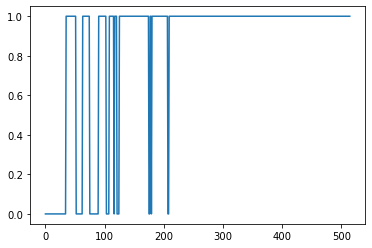

In [11]:
plt.plot(predicted)
print('Confusion Matrix:\n',metrics.confusion_matrix(y, predicted))
print('Model Score =',model.score(X))

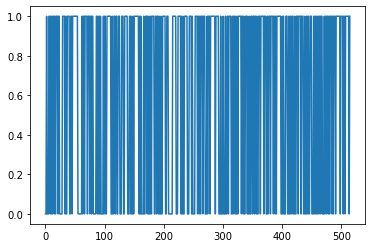

In [12]:
plt.plot(y)

balance 0.8524271844660194
valid auc: 0.5386309857400834
                    1   macro avg  weighted avg
precision    0.603645    0.551822      0.560979
recall       0.874587    0.526916      0.588350
f1-score     0.714286    0.489087      0.528880
support    303.000000  515.000000    515.000000
                 0
accuracy  0.588350
AUC       0.538631


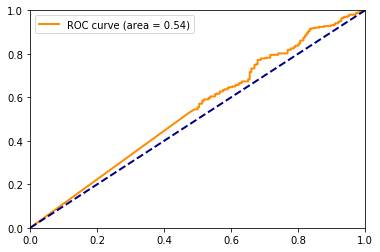

In [13]:
# run an accuracy or auc test
from sklearn.metrics import roc_curve, auc, accuracy_score
 
# balance
print('balance', np.mean(predicted))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
print('valid auc:',roc_auc)
report = metrics.classification_report(y, predicted,output_dict=True)
get_performance(report,roc_auc,model.score(X))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()